# 04 — Monte Carlo Random Search

**Objectif :** implémenter une méthode Monte Carlo simple :
- générer $(K$) plannings aléatoires,
- simuler et évaluer chaque planning,
- conserver le meilleur (*best-so-far*),
- tracer une courbe de convergence.

Cette approche constitue une baseline Monte Carlo avant d’introduire un Monte Carlo amélioré
(recuit simulé) dans le notebook suivant.


In [10]:
import os
from pathlib import Path

# Racine Colab
BASE_DIR = Path("/content")

# Dossiers projet
INSTANCES_DIR = BASE_DIR / "data" / "instances"
RESULTS_DIR   = BASE_DIR / "data" / "results"

# Créer results si absent
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("INSTANCES_DIR:", INSTANCES_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("Instance exists:", (INSTANCES_DIR / "instance_50jobs_5machines.json").exists())


INSTANCES_DIR: /content/data/instances
RESULTS_DIR: /content/data/results
Instance exists: True


## 1) Chargement de l’instance et fonctions utilitaires

On réutilise les fonctions :
- validation solution
- simulation
- métriques / score


In [2]:
def load_instance(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def is_valid_solution(solution, n_jobs):
    flat = [job for seq in solution for job in seq]
    return (len(flat) == n_jobs) and (sorted(flat) == list(range(n_jobs)))

def simulate(instance, solution):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    p = instance["processing_times"]
    releases = instance.get("releases", None)
    if releases is None:
        releases = [0.0] * n_jobs

    start = [0.0] * n_jobs
    end = [0.0] * n_jobs
    machine_time = [0.0] * n_machines

    for k in range(n_machines):
        t = 0.0
        for j in solution[k]:
            t = max(t, float(releases[j]))
            start[j] = t
            t = t + float(p[j][k])
            end[j] = t
        machine_time[k] = t

    Cmax = max(end) if end else 0.0
    return {"start": start, "end": end, "machine_time": machine_time, "Cmax": Cmax}

def compute_metrics(instance, sim, alpha=1.0, beta=0.2, gamma=0.0):
    end = sim["end"]
    Cmax = float(sim["Cmax"])

    deadlines = instance.get("deadlines", None)
    weights = instance.get("weights", None)

    sumT = 0.0
    sumWT = 0.0

    if deadlines is not None:
        for j in range(instance["n_jobs"]):
            tj = max(0.0, float(end[j]) - float(deadlines[j]))
            sumT += tj
            if weights is not None:
                sumWT += float(weights[j]) * tj

    score = alpha * Cmax + beta * sumT + gamma * sumWT
    return {"Cmax": Cmax, "sumT": sumT, "sumWT": sumWT, "score": score}


In [3]:
instance_path = "/content/data/instances/instance_50jobs_5machines.json"
instance = load_instance(instance_path)

print("Loaded:", instance["name"])
print("n_jobs:", instance["n_jobs"], "| n_machines:", instance["n_machines"])
print("deadlines:", instance.get("deadlines") is not None)


Loaded: instance_50jobs_5machines
n_jobs: 50 | n_machines: 5
deadlines: True


## 2) Génération aléatoire de solutions (sampling)

On définit une fonction qui génère un planning aléatoire valide :
- assignation machine aléatoire
- ordre aléatoire sur chaque machine

C’est le générateur de candidats pour Monte Carlo Random Search.


In [4]:
def random_solution(instance, rng):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]

    jobs = list(range(n_jobs))
    rng.shuffle(jobs)

    sol = [[] for _ in range(n_machines)]
    for j in jobs:
        k = rng.randrange(n_machines)
        sol[k].append(j)

    for k in range(n_machines):
        rng.shuffle(sol[k])

    return sol


## 3) Algorithme Monte Carlo Random Search

Principe :
- répéter $(K$) fois :
  - générer un planning aléatoire
  - simuler et calculer le score
  - mettre à jour le meilleur (*best-so-far*)

On enregistre aussi l’historique du meilleur score pour tracer la convergence.


In [5]:
def mc_random_search(instance, K=2000, seed=0, alpha=1.0, beta=0.2, gamma=0.0):
    rng = random.Random(seed)

    best_sol = None
    best_met = None
    best_score = float("inf")

    history = []
    start_time = time.time()

    for i in range(K):
        sol = random_solution(instance, rng)
        assert is_valid_solution(sol, instance["n_jobs"])
        sim = simulate(instance, sol)
        met = compute_metrics(instance, sim, alpha=alpha, beta=beta, gamma=gamma)

        if met["score"] < best_score:
            best_score = met["score"]
            best_sol = sol
            best_met = met

        history.append(best_score)

    elapsed = time.time() - start_time
    return best_sol, best_met, history, elapsed


## 4) Exécution sur une instance

On exécute Monte Carlo Random Search avec un nombre de tirages $(K$).


In [6]:
alpha, beta, gamma = 1.0, 0.2, 0.0
K = 5000
seed = 0

best_sol, best_met, history, elapsed = mc_random_search(
    instance, K=K, seed=seed, alpha=alpha, beta=beta, gamma=gamma
)

print("K:", K, "| elapsed (s):", round(elapsed, 3))
print("Best metrics:", best_met)


K: 5000 | elapsed (s): 0.584
Best metrics: {'Cmax': 98.0, 'sumT': 83.80027928101104, 'sumWT': 0.0, 'score': 114.76005585620221}


## 5) Courbe de convergence

On trace le meilleur score trouvé (*best-so-far*) en fonction du nombre d’itérations.
Une décroissance rapide indique une exploration efficace par échantillonnage.


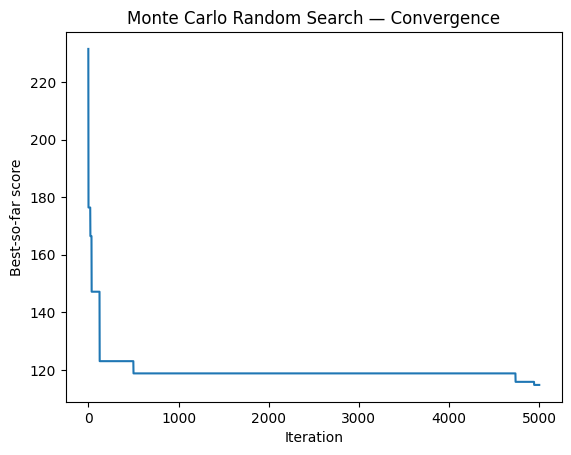

In [7]:
plt.figure()
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best-so-far score")
plt.title("Monte Carlo Random Search — Convergence")
plt.show()


## 6) Comparaison avec une baseline random moyenne (sanity check)

Pour vérifier le gain apporté par la sélection du meilleur tirage,
on compare le meilleur score obtenu à la moyenne de plusieurs tirages aléatoires.


In [8]:
def random_score(instance, seed, alpha=1.0, beta=0.2, gamma=0.0):
    rng = random.Random(seed)
    sol = random_solution(instance, rng)
    sim = simulate(instance, sol)
    met = compute_metrics(instance, sim, alpha=alpha, beta=beta, gamma=gamma)
    return met["score"]

seeds = list(range(50))
scores = [random_score(instance, s, alpha, beta, gamma) for s in seeds]

print("Random mean score:", float(np.mean(scores)))
print("Random std score :", float(np.std(scores, ddof=1)))
print("MC best score    :", best_met["score"])


Random mean score: 241.21853014876007
Random std score : 56.92520882696394
MC best score    : 114.76005585620221


## 7) Sauvegarde du meilleur planning

On sauvegarde :
- la meilleure solution (séquences par machine)
- les métriques associées
- les paramètres (K, seed, poids du score)

Les fichiers sont écrits dans `data/results/`.


In [11]:
import json

out_path = RESULTS_DIR / f"best_mc_random_{instance['name']}.json"

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved:", out_path)


Saved: /content/data/results/best_mc_random_instance_50jobs_5machines.json


## 8) Conclusion

La recherche Monte Carlo par échantillonnage aléatoire permet d’améliorer significativement
la baseline Random en sélectionnant le meilleur planning parmi \(K\) tirages.

Cependant, cette approche reste limitée :
- elle ne “réutilise” pas l’information des bons plannings trouvés,
- elle peut nécessiter beaucoup de tirages pour progresser davantage.

 Prochaine étape : **05_MonteCarlo_Improved_Search.ipynb**
- utiliser un Monte Carlo amélioré (recuit simulé),
- explorer localement autour des meilleures solutions,
- obtenir de meilleures performances pour un budget de calcul comparable.
